In [83]:
from pathlib import Path
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import roc_auc_score

from sklearn.metrics import roc_auc_score

plt.style.use('seaborn-white')

In [84]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [85]:
def evaluate_score(score):
    mean = np.mean(score)
    std = np.std(score)
    print(f"Average score:{mean}+/-{std}%")
    plt.boxplot(scores)


In [86]:
from pylab import rcParams
rcParams['figure.figsize'] = 11, 10

We define two labels for our datasets ,1 for normal and 2 for problematic scenarios. 

In [87]:
normal_labels = np.zeros((20,1))

In [88]:
error_labels = np.ones((60,1))

Our dataset is spread over many csv files. We keep only the voltage series, add a label column and concatanate all dataframes into one.
So now we have one dataset which rows are sampled sequences and the last column is the label (1 or 0) of this sequence.
Now we can train a classifier to tell apart the normal from the problematic sequences.

In [89]:
df_normal_list = pd.DataFrame()
pathlist = Path("/home/aggelos-i3/Downloads/simu Elbas/7h33NO").glob('**/*.xls')
for path in pathlist:
    # because path is object not string
    path_in_str = str(path)
    df = pd.read_csv(path_in_str, delimiter='\t')
    df = df[['voltage [V]']][:1000].transpose()
    #df = df.set_index("loc. (actual) [km]")
    #df.dropna(inplace=True)
    #df.sort_index(inplace=True)
    if df_normal_list.empty:
        df_normal_list = df
    else:
        df_normal_list = df_normal_list.append(df)


In [90]:
df_error_list = pd.DataFrame()
for i in range(1, 4):
    pathlist = Path(
        f"/home/aggelos-i3/Downloads/simu Elbas/7h33D{i}").glob('**/*.xls')
    for path in pathlist:
        # because path is object not string
        path_in_str = str(path)
        df = pd.read_csv(path_in_str, delimiter='\t')
        df = df[['voltage [V]']][:1000].transpose()
        #df = df.set_index("loc. (actual) [km]")
        # df.dropna(inplace=True)
        if df_error_list.empty:
            df_error_list = df
        else:
            df_error_list = df_error_list.append(df)

In [91]:
X = pd.concat([df_normal_list, df_error_list], axis=0)
X.shape
dataset = X

In [92]:
y = np.concatenate([normal_labels, error_labels], axis=0)
dataset['labels'] = y.astype(int)

In [93]:
# we shuffle our dataset
class_names = np.array(['Error', 'Normal'])

dataset = shuffle(dataset)
dataset.dropna(inplace=True)
dataset.describe()

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,labels
count,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,...,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000
mean,785.702467,784.541579,783.542122,782.348837,780.648544,783.452133,782.923596,783.864854,782.143424,782.167913,...,801.422497,782.697047,787.664675,786.069158,789.841161,789.882719,790.402818,787.219369,786.160804,0.750000
std,5.284320,2.656379,3.011840,2.588998,3.572224,9.013017,4.675291,4.879789,5.709653,10.835386,...,23.218355,16.384524,4.925348,4.736562,5.157069,7.106287,7.984407,6.254225,4.726753,0.435745
min,774.184326,777.300232,774.372314,775.529236,769.735657,765.522522,768.686768,769.519897,766.412170,763.242676,...,784.174622,762.627258,778.934753,776.062683,777.762268,772.329956,772.211731,768.036743,769.358704,0.000000
25%,783.361847,783.721146,782.214233,781.181992,779.223801,778.418137,781.181366,783.083786,779.337616,776.903015,...,787.392166,770.962219,783.873825,783.384674,787.987701,785.533051,786.261414,783.823013,784.289139,0.750000
50%,785.050385,784.564758,784.086212,782.169281,781.313416,781.223023,783.207153,784.421722,781.414978,780.072662,...,790.834381,774.987183,786.749115,785.364258,788.792206,788.450745,788.827332,786.668091,786.621582,1.000000
75%,787.129425,786.112823,785.721375,784.270752,782.675308,785.652252,785.873917,785.655685,786.581039,785.104340,...,807.354675,791.529755,791.242844,789.750534,790.420853,792.997620,793.622482,790.620651,788.308701,1.000000
max,804.759766,789.580139,787.957275,786.837707,787.134705,810.300293,790.527100,792.941528,791.987061,812.330322,...,880.260742,833.462219,800.511536,798.087769,809.265320,808.796814,814.559753,800.787537,796.938782,1.000000


In [94]:
scaler  = StandardScaler()
X, y = dataset.iloc[:, :-1].values, dataset.iloc[:, -1].values
X = scaler.fit_transform(X)
# split our dataset 0.75 train 0.25 test
# although since our dataset is smalll we will later user kfold crossvalidation 
X_train, X_test, y_train, y_test = train_test_split(X, y)
# fit model no training data
eval_set = [(X_test, y_test)]

model = XGBClassifier()
model.fit(
    X_train,
    y_train,
    early_stopping_rounds=10,
    eval_metric="logloss",
    eval_set=eval_set,
    verbose=False)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
conf_matr = confusion_matrix(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 85.00%


Normalized confusion matrix
[[0.5    0.5   ]
 [0.0625 0.9375]]


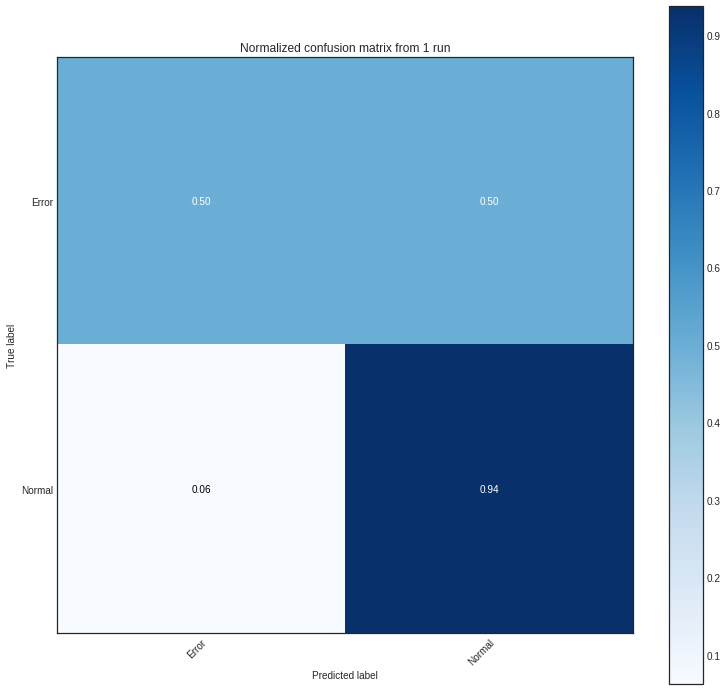

In [95]:
plot_confusion_matrix(y_test, predictions, classes=class_names, normalize=True,
                      title='Normalized confusion matrix from 1 run')

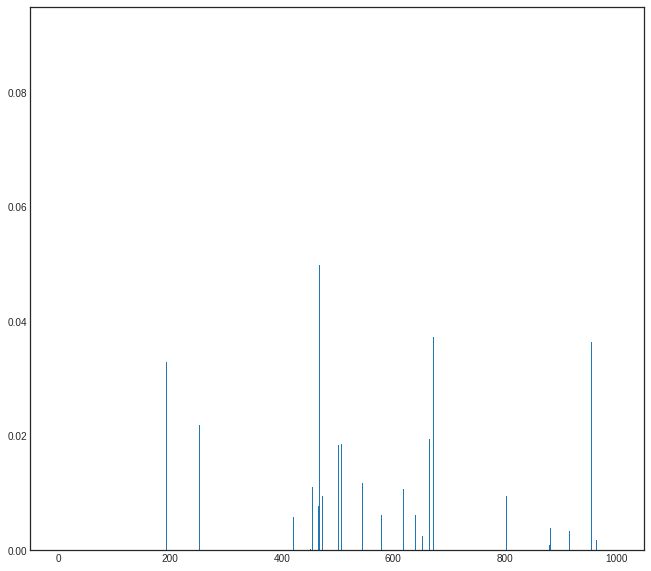

In [96]:
# plot
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

In [109]:
xgtrain = xgb.DMatrix(X, y)
xgb_param = model.get_xgb_params()
#do cross validation
print ('Start cross validation')
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=5000, nfold=15, metrics=['auc'],
     early_stopping_rounds=50, stratified=True, seed=1301)

Start cross validation


In [110]:
print('Best number of trees = {}'.format(cvresult.shape[0]))
model.set_params(n_estimators=cvresult.shape[0])

Best number of trees = 15


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=15,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [111]:
print('Fit on the trainingsdata')
model.fit(X_train, y_train, eval_metric='auc')
print('Overall AUC:', roc_auc_score(y, model.predict_proba(X)[:,1]))
print('Predict the probabilities based on features in the test set')
pred = model.predict_proba(X_test, ntree_limit=cvresult.shape[0])

Fit on the trainingsdata
Overall AUC: 0.9820833333333333
Predict the probabilities based on features in the test set


Average score:0.775+/-0.14577379737113252%


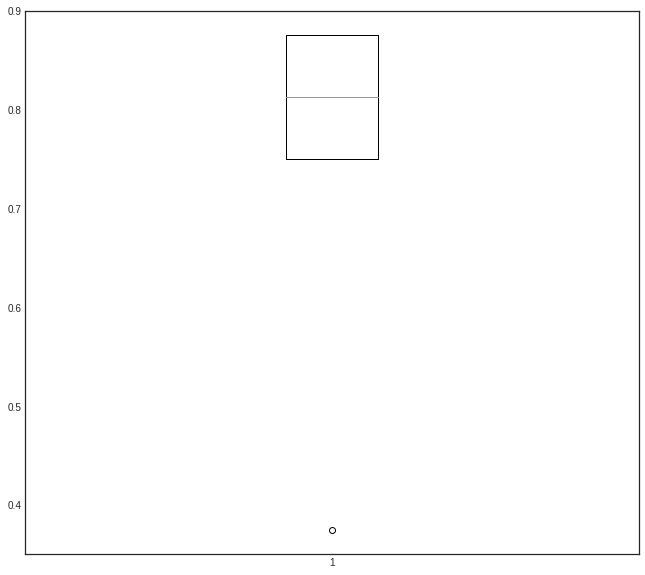

In [112]:
#Kfold
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score

kf = StratifiedKFold(n_splits=10)
scores = cross_val_score(model, X, y, cv=kf, n_jobs=-1)
evaluate_score(scores)

Normalized confusion matrix
[[0.3        0.7       ]
 [0.06666667 0.93333333]]


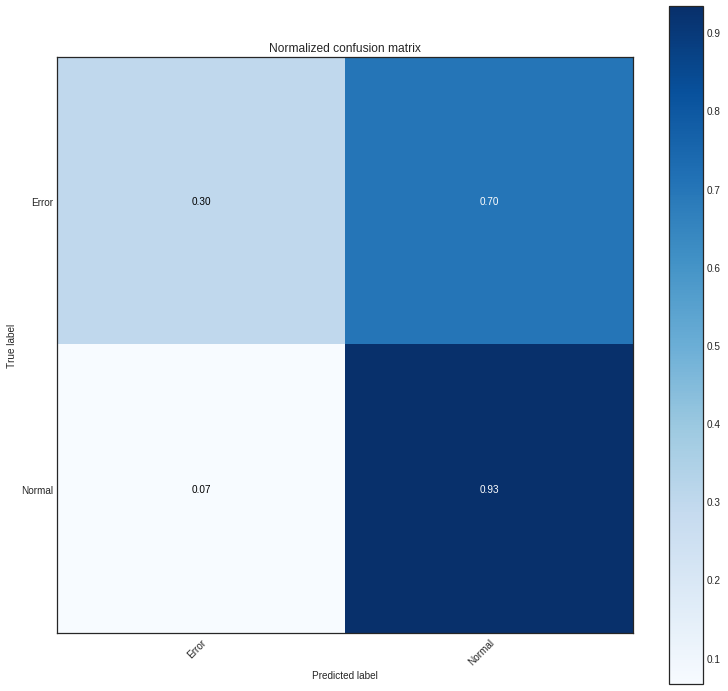

In [113]:
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(model, X, y, cv=10)
conf_mat = confusion_matrix(y, y_pred)
plot_confusion_matrix(y, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

# Support Vector Machine 

In [349]:
 from sklearn.svm import SVC

In [354]:
model = SVC(gamma='auto', kernel='rbf')

In [357]:
scores = cross_val_score(model, X, y, cv=kf, n_jobs=-1)
print(scores)

[0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75]


Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


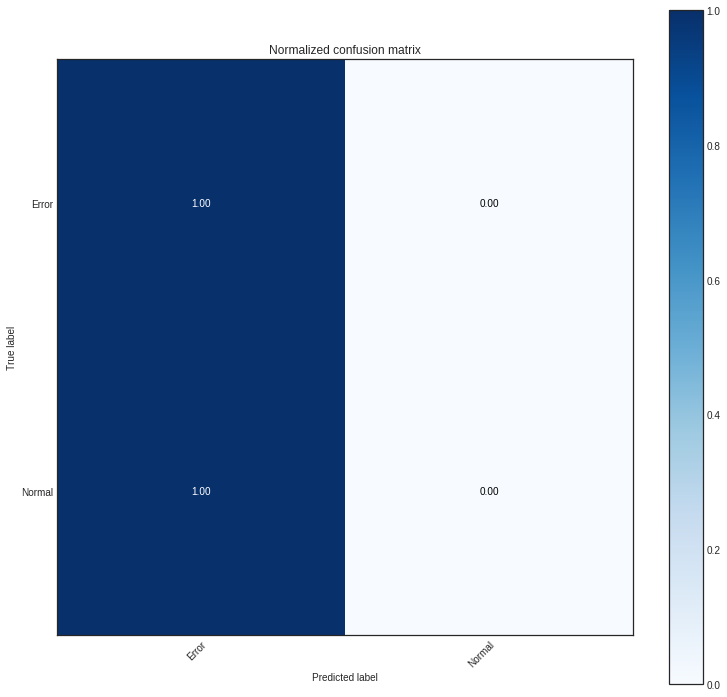

In [356]:
y_pred = cross_val_predict(model, X, y, cv=10)
conf_mat = confusion_matrix(y, y_pred)
plot_confusion_matrix(y, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

#    Naive Bayes Classifier

In [367]:
from sklearn.naive_bayes import GaussianNB, ComplementNB
scaler = MinMaxScaler((0,1))
X = scaler.fit_transform(X)
model = GaussianNB()
scores = cross_val_score(model, X, y, cv=kf, n_jobs=-1)
print(scores)

[0.5   0.625 0.625 0.5   0.25  0.625 0.625 0.375 0.625 0.625]


Normalized confusion matrix
[[0.71666667 0.28333333]
 [1.         0.        ]]


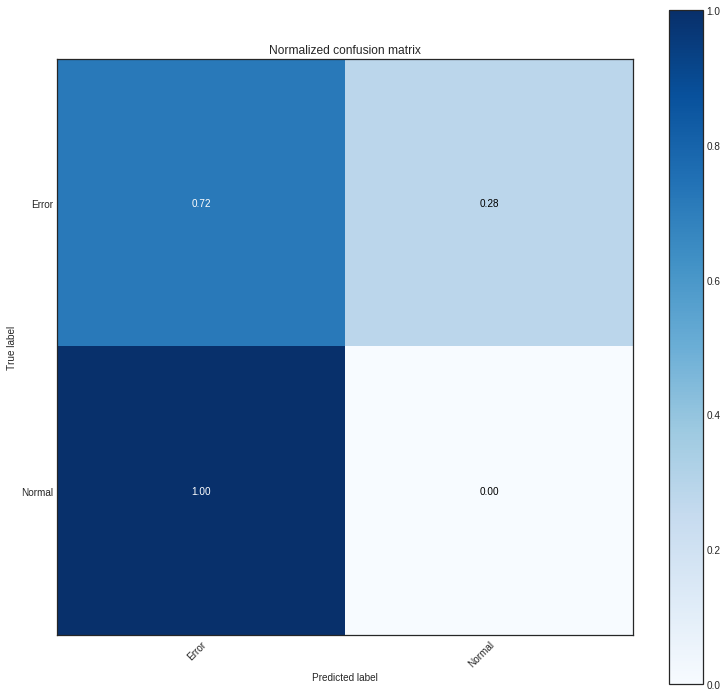

In [368]:
y_pred = cross_val_predict(model, X, y, cv=10)
conf_mat = confusion_matrix(y, y_pred)
plot_confusion_matrix(y, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

# Gradient Boost Classifier

In [387]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier

Average score:0.775+/-0.1346291201783626%


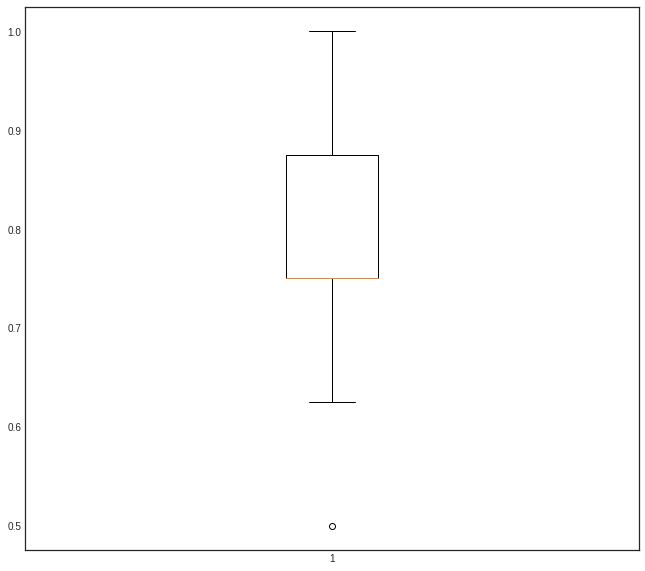

In [391]:
kf = StratifiedKFold(n_splits=10)
scores = cross_val_score(model, X, y, cv=kf, n_jobs=-1)
evaluate_score(scores)

Normalized confusion matrix
[[0.88333333 0.11666667]
 [0.55       0.45      ]]


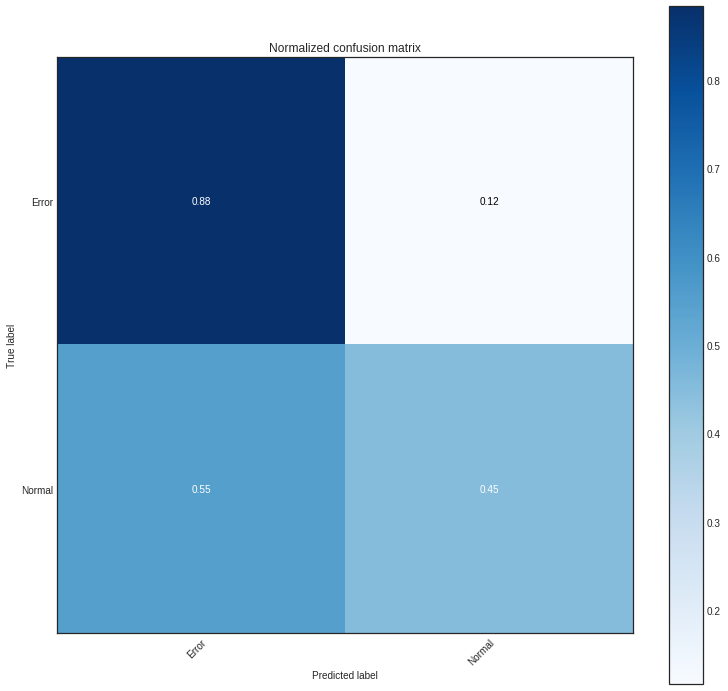

In [392]:
y_pred = cross_val_predict(model, X, y, cv=10)
conf_mat = confusion_matrix(y, y_pred)
plot_confusion_matrix(y, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')